# Sematic Search with Pinecone

Pinecone is a managed vector database that’s designed to scale semantic search and retrieval without worrying about the underlying infrastructure. Unlike local options like ChromaDB, Pinecone runs in the cloud, so it’s especially useful when:
- You need to handle large collections (millions or even billions of vectors).
- You want high availability and low-latency queries without managing servers yourself.
- You care about production-grade reliability. Pinecone takes care of sharding (splitting the data into smaller chunks called shards), replication and indexing behind the scenes.

We'll explore how to do semantic search with this database. The workflow will feel familiar:
1. connecting to a Pinecone index
2. inserting documents as vectors
3. running semantic queries to retrieve the most relevant results

# Setup: Installing Required Libraries

Before we begin, we need to install the necessary Python libraries. Run the cell below to install all dependencies for this notebook.

In [ ]:
# Install required libraries
!pip install -q pinecone==7.3.0 transformers==4.55.0 pandas==2.3.1 sentence-transformers==3.3.1 torch==2.5.1

print("✅ All libraries installed successfully!")

# 1. Loading the Data and Basic Preprocessing

In [ ]:
import pandas as pd
import os
from pinecone import Pinecone, ServerlessSpec

Let's load the data we'll be working with. The original dataset contains 2,500 articles published on the website Medium:

In [ ]:
# Loading
data = pd.read_csv("articles.csv")

Each row in the DataFrame represents 1 article. For each article, we have both the full text and a set of useful descriptive columns such as authors, timestamp and tags.

In [ ]:
# Inspecting
data.head()

The full body of the article is stored in "text" column:

In [ ]:
data.text[10]

The original article can be accessed via URL address stored in "url" column:

In [ ]:
data.url[10]

Let's make some basic preprocessing of the data:

In [ ]:
# Ensure the text is a string and strip whitespace
data["text"] = data["text"].astype(str).str.strip()

In [ ]:
# Converting values in "tags" column to Python lists (so that we can filter results by tags later on)
import ast
data["tags"] = data["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
# Converting values in "authors" column to Python lists (so that we can filter results by authors later on)
data["authors"] = data["authors"].apply(lambda x: x if isinstance(x, list) else (ast.literal_eval(x) if pd.notna(x) else []))

In [ ]:
# Checking the types after conversion
print(type(data.tags[0]),
      type(data.authors[0]) )

In [ ]:
# "timestamp" holds the original timestamps - converting them to pandas Datetime objects
ts = pd.to_datetime(data["timestamp"], utc=True, format="mixed", errors="coerce")

# ISO 8601 formatted string version of the timestamp for display purposes
data["timestamp_iso"] = ts.dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# Exctracting just the year from the timestamp (so that we can filter results by year later on)
data["year"] = ts.dt.year.astype("Int64")

# 2. Creating Pinecone Account  

First, sign up for a Pinecone account at their website - there’s **a free Starter plan**. Navigate to **API Keys** section and click "Create API key". **Store it safely** because you won’t be able to see it again once you close the dialog. You'll use this API key to authenticate your notebook when it interacts with Pinecone.

You can make your Pinecone API key load automatically every time your terminal starts by adding it to your shell startup file. Open the terminal and type `nano ~/.zshrc`. At the end of the file, add: `export PINECONE_API_KEY="your_api_key"`. Save and exit. Then reload your shell config (so the change applies immediately) using `source ~/.zshrc`.

Now, we'll create a client for interacting with the Pinecone account:

In [ ]:
import os

# Configure Pinecone API key
PINECONE_API_KEY = None

try:
    from google.colab import userdata  # type: ignore
    PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
    if PINECONE_API_KEY:
        print('✅ API key loaded from Colab secrets')
except Exception:
    pass

if not PINECONE_API_KEY:
    PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')

if not PINECONE_API_KEY:
    try:
        from getpass import getpass
        print('💡 To use Colab secrets: Go to 🔑 (left sidebar) → Add new secret → Name: PINECONE_API_KEY')
        PINECONE_API_KEY = getpass('Enter your Pinecone API Key: ')
    except Exception as exc:
        raise ValueError('❌ ERROR: No API key provided! Set PINECONE_API_KEY as an environment variable or Colab secret.') from exc

if not PINECONE_API_KEY or PINECONE_API_KEY.strip() == '':
    raise ValueError('❌ ERROR: No API key provided!')

os.environ['PINECONE_API_KEY'] = PINECONE_API_KEY

print('✅ Pinecone authentication configured!')

In [ ]:
# Client
pinecone_client = Pinecone(api_key=PINECONE_API_KEY)

# 3. Types of Indexes for Vector Embeddings

Okay, we've covered the essentials: loading the data and setting up Pinecone client. Now, it's time to understand how Pinecone actually **stores and searches our data**. We'll begin with indexes.

Pinecone utilizes 2 types of indexes for vector embeddings:

a) **dense indexes**:
- they store dense vectors which are numerical representations of data trasnformed into a vector of **floating-pont numbers**
- they are **fundamental for semantic search** = allow a system to understand the user's **intent** and **the contextual meaning of a query**, rather than relying on exact keyword matching
- *Example:  a search for "what to wear in cold weather" could yield results for "winter coats" or "wool sweaters", even if those exact words are not in the query*

b) **sparse indexes**:
- they store sparse vectors, which primarily represent **keyword information**
- they have most of their values as zero, with only a few non-zero values indicating the presence or importance of specific terms
- effective at **keyword matching**
- useful when precision is required for **specific entities**, such as product names, part numbers, or unique identifiers, where an exact term match is crucial





## 3.1 Creating an Index

Now, we will create a dense index using `create_index()`. We also need to decide how many dimensions each stored vector will have by specifing `dimension` parameter. This value **must exactly match the size of the vectors produced by our embedding model**.

In our demo, we’ll use the Hugging Face model `all-MiniLM-L6-v2` (Section 4. Creating Embeddings). According to its model card, this model **maps each sentence or paragraph to a 384-dimensional dense vector**. That means every embedding it produces is an array of 384 numbers.

If our Index was created with a different dimension value, Pinecone would reject our data because the vectors wouldn’t "fit" the index structure.

Paramer `metric` specifies how Pinecone measures similarity between vectors. We'll set **"cosine"** which compares their orientation (angle) rather than magnitude, making it ideal for semantic similarity tasks like our text search.

Finally, we will specify `cloud` and `region` to tell Pinecone **where we want our index deployed**, letting Pinecone manage the infrastructure automatically.

> NOTE: On the free Starter plan, we can create serverless indexes in **"us-east-1" region of AWS only**.

In [ ]:
# Creating an Index
pinecone_client.create_index(name = "demo-articles",
                             dimension = 384,
                             metric = "cosine",
                             spec = ServerlessSpec(
                                 cloud = "aws",
                                 region = "us-east-1"
                             ))

### 📝 EXERCISE 1: Inspect Your Pinecone Index (3-5 minutes)

**What you'll practice:** Understanding Pinecone index properties and configuration.

**Your task:**
1. Use the Pinecone client to describe your index and check its stats
2. Print out key information: dimension size, metric type, and total vector count
3. Think about: Why does the dimension size matter? What would happen if you tried to insert vectors of a different size?

**Hint:** You can use `pc.describe_index(INDEX_NAME)` to get index details and `index.describe_index_stats()` to see statistics.

**Expected outcome:** You should see that your index is configured for 384-dimensional vectors (matching the embedding model) and uses cosine similarity metric.

In [ ]:
# YOUR CODE HERE
# Example solution structure:
# index_info = pc.describe_index(INDEX_NAME)
# print("Index configuration:")
# print(f"  Dimension: {index_info.dimension}")
# print(f"  Metric: {index_info.metric}")
# 
# stats = index.describe_index_stats()
# print(f"\nIndex statistics:")
# print(f"  Total vectors: {stats.get('total_vector_count', 0)}")

The output above confirms that the Pinecone index "demo-articles" has been successfully created and is ready to use. If you go back to your Pinecone dashboard and refresh, you should see "demo-articles" listed under your indexes.

When you click on the index, you’ll see that Record Count shows 0, meaning no vectors have been inserted yet. The Browser tab lists all records stored in the index, so right now it’s an empty space ("No records yet"). This is expected, we’ve only created the index structure.

In [ ]:
# Connect to the index
index_name = "demo-articles"
index = pinecone_client.Index(index_name)

print(f"✅ Connected to index: {index_name}")

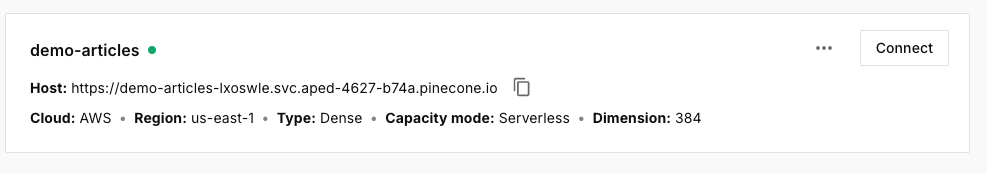

# 4. Creating Embeddings

To generate vector representations (embeddings) of our text, we need an embedding model. We'll use small and efficient `all-MiniLM-L6-v2` model from Hugging Face’s `sentence-transformers` library. You can read more about this model on [Hugging Face](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

We use `SentenceTransformer()` to download the model weights, configuration and tokenizer from Hugging Face and set up everything needed to compute embeddings:

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2', device = "cpu") # forces the model to run on CPU only, regardless of GPU availability
model

> NOTE: Picking a model hosted by Pinecone

>In addition to uploading your own embeddings, Pinecone also offers hosted embedding models that can generate embeddings directly within the platform. You can find these in your Pinecone dashboard under the "Inference" section. These models such as NVIDIA’s llama-text-embed-v2 are optimized for high retrieval quality, support multiple languages, and save you the step of running a separate embedding model locally. However, it’s important to note that these hosted models are not free, usage is billed based on the number of tokens processed.

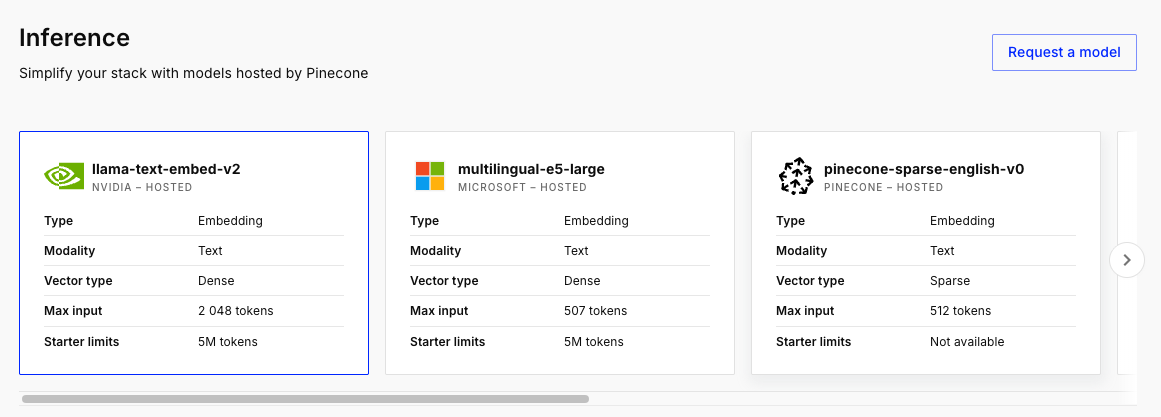

In [ ]:
texts = data["text"].tolist()

# Creating embeddings
embeddings = model.encode(
    texts,
    batch_size = 64,                # adjust if you hit RAM limits
    show_progress_bar = True,
    convert_to_numpy = True,        # get NumPy array back (easier to store)
    normalize_embeddings = False    # set to False because Pinecone computes cosine itself
)

# Storing embeddings back into the DataFrame as Python lists
data["values"] = [vec.tolist() for vec in embeddings]

Now you can see the actual vector representations in "values" column:

In [ ]:
data.head(2)

Also, we need to make sure the data is in a clean and consistent format that Pinecone’s API can understand (no NaN values, the correct type):

In [ ]:
data.isnull().sum()

For this demo, let's just drop it from the DataFrame:

In [ ]:
data.dropna(inplace=True)

Next we reset the original index and create a new column "id" with unique identifiers (additionally, we'll convert the values to strings). Pinecone will identify vectors by their IDs.

In [ ]:
data = data.reset_index(drop=True)
data["id"] = data.index.astype(str)

# 5. Attaching Metadata
Before we insert our embeddings into Pinecone, let’s prepare some metadata. These are small pieces of extra information that describe each vector. Metadata doesn’t affect the math of similarity search, but they’re extremely valuable for **organizing, filtering and presenting search results**:

1. **Adding context to search results**: Metadata lets you display useful details like the article title, author, or date directly alongside the retrieved results.

2. **Filtering**: You can filter search results by metadata values, for instance returning results from a certain date range, author or category. We’ll explore filtering later in the notebook.

The decision of what to store in metadata depends on:
- What you plan to filter on
- What you want to show after retrieval


For our dataset, a practical set of metadata fields would be, for example:
- "authors" → for filtering or attribution
- "timestamp" → for sorting or date filtering
- "tags" → for topical filtering



In [ ]:
# Creating "metadata" column
data['metadata'] = data.apply(lambda x: {
    "title": x["title"],
    "authors": x["authors"],
    "timestamp": x["timestamp_iso"],
    "year": x["year"],
    "tags": x["tags"]
}, axis=1)

In [ ]:
# IDs of documents along with their metadata
for _id, meta in data[["id", "metadata"]].head().values:
    print(f"ID: {_id}")
    print("Metadata:", meta)
    print("-" * 40)

Now we'll create a DataFrame with columns that should be upserted into a database:

In [ ]:
# Creating a new DataFrame
df_upsert = data[['id', 'values', 'metadata']]

In [ ]:
df_upsert.head(2)

# 6. Namespaces

Before we move on to upserting our data into Pinecone, let's take a look at another powerful feature - **namespaces**. They are like logical partitions within a single Pinecone index that let you **group data in isolation**. You can think of them as subfolders inside a file directory. Everything lives in the same index, but separated into named "places" that you can write to, query or clear independently.

Let's take a look at the main advantages:

**1. Multitenancy and Isolation**:
Namespaces are **ideal when multiple users, teams or clients share the same index but need to keep their data separate**.

For example, imagine we’re building a semantic search tool for a law firm. Instead of creating a separate index for each team, we create one index with multiple namespaces:
- Namespace "team-A": contains only contracts and case files relevant to Team A
- Namespace "team-B": contains only materials for Team B
- Namespace "team-C": contains only materials for Team C

When someone from Team A runs a query, Pinecone searches only within "team-A", so there’s no risk of retrieving Team B or Team C’s data.

**2. Cost Efficiency and Performance**:
By restricting searches to a specific namespace, Pinecone scans only a portion of the index instead of the entire dataset. This **reduces latency** (faster results) and **operation costs**, which is especially valuable if you have thousands or millions of records.

**3. Easy Data Management**:
If you ever need to remove all content for a particular team, you can simply delete that team’s namespace. This instantly clears their data without affecting any other team’s vectors.

> NOTE: If we don’t specify a namespace when upserting data, Pinecone **automatically stores the records in the default namespace**.



# 7. Upserting Data into Pinecone
We’ll use `upsert_from_dataframe()` function, which automatically batches our DataFrame and uploads it efficiently. Pinecone recommends making batches as large as possible, **up to 1 000 records, without exceeding the 2 MB per-request limit**.


For our 384-dimension vectors, each vector is ~1.5 KB (384 × 4 bytes). For our dataset of 9999 vectors, the total payload for just the vector data is ~14 MB (far over Pinecone’s 2 MB per-request limit). This does not include IDs, metadata and HTTP request overhead which also contribute to the total payload size. Sending all vectors in one go would result in an error.

Hence, we'll set `batch_size = 500`. This is a safe starting point that keeps us well under request size limit. Feel free to experiment by increasing this value towards 1000 to see if you can achieve faster upsert speeds without exceeding the ~2 MB limit.


In [ ]:
# Upserting the data
index.upsert_from_dataframe(
    df_upsert,
    namespace = "client_A",
    batch_size = 500,
    show_progress = True)

Once `upsert_from_dataframe()` step finishes, go to your Pinecone web console and refresh the page for your index. You should now see  Record Count updated to 9999. This number represents the total number of vectors we’ve just inserted into the index.

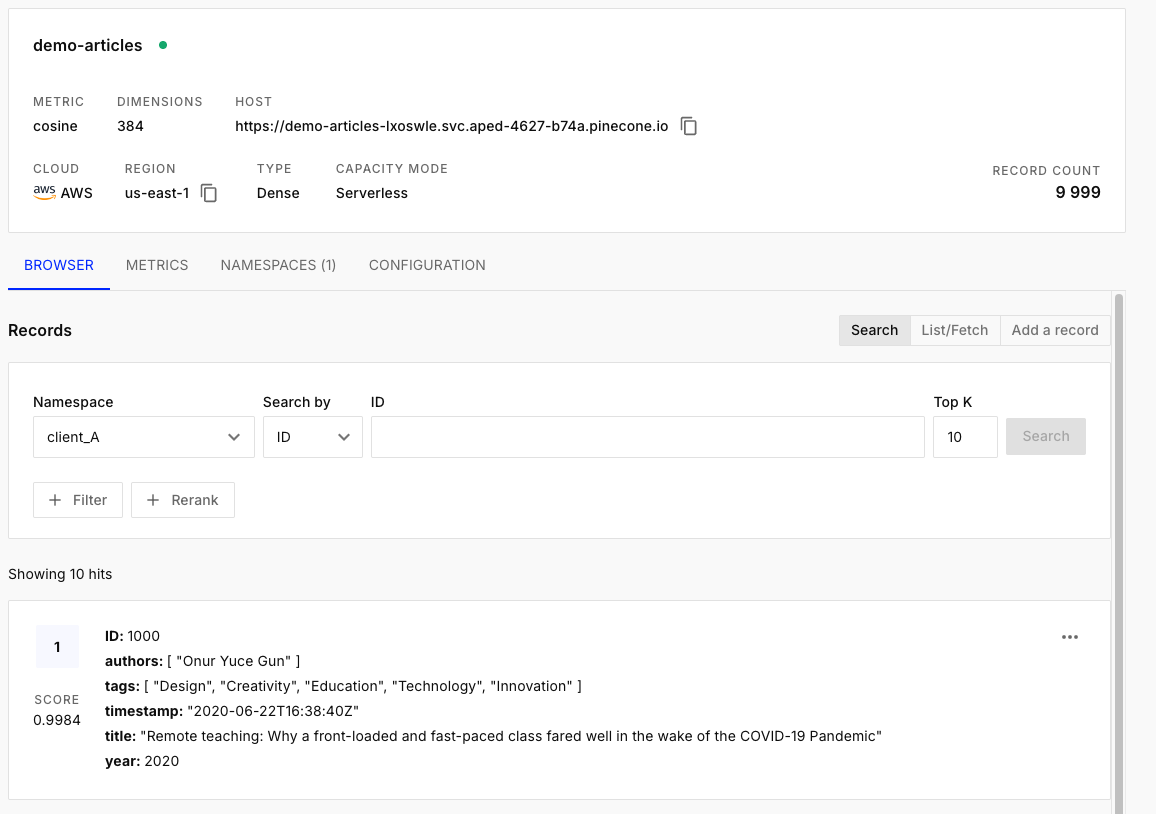

## 7.1 Upserting Data: Manual Batched Upserts

However, not all workflows start with a DataFrame. In some projects, your vectors may come from a live data stream, a generator function or another format entirely. In those cases, you can manually batch your records and upsert them using `upsert()`.

This approach is useful when:
1. **Your data isn’t a DataFrame**: e.g., using generators, streaming data or custom collections.
2. **You want fine-grained control**: such as dynamic batch sizes or pre-processing each batch separately.
3. **You need to ensure payload size limits (2 MB per request) aren’t exceeded**: Manually adjusting batch sizes helps manage large metadata or vector sizes.
4. **You want to implement parallel uploads**: sending multiple batches concurrently can drastically improve throughput.

You can read more in [the documentation](https://docs.pinecone.io/guides/index-data/upsert-data#upsert-in-batches).



# 8. Querying the Database

Now that we’ve upserted our vectors, we can start querying it. First, we'll connect to the Index:

In [ ]:
# Connecting
index = pinecone_client.Index("demo-articles")

This will be our query:

In [ ]:
# Our question
query_text = "What are some good books for learning Python?"

Now we'll create the query vector with the SAME embedding model we used for indexing:

In [ ]:
query_vector = model.encode(query_text, convert_to_numpy=True)

# Pinecone expects a plain Python list of floats
query_vector = query_vector.tolist()

We'll use `query()` function which:
- **searches for similar vectors**
- **returns the results**: `top_k = 5` returns top 5 results, and `include_metadata = True` returns any extra information we stored with those vectors


> NOTE: Pinecone imposes **4 MB response size limit**. If you request too many results or include large metadata values, the query might fail. If needed, switch `include_metadata=False` or lower `top_k` parameter.

In [ ]:
# Querying the database
responses = index.query(
    vector = query_vector,
    top_k = 5,
    include_metadata = True,
    namespace = "client_A"
)

In [ ]:
# Printing the results
responses

Let's loop through responses and round scores to make the output readable and easy to interpret. For every match, we see:
- **ID** → the unique identifier of the stored vector/document
- **Score** → the similarity score between our query vector and the document’s vector (higher = more relevant)
- **Metadata** → the descriptive fields we stored along with each document

In [ ]:
# Displaying the results in a clean format
for respose in responses["matches"]:
    print(f"ID: {respose['id']}")
    print(f"Score: {respose['score']:.4f}")
    metadata = respose.get("metadata", {})
    print("Metadata:")
    for key, value in metadata.items():
            print(f" {key}: {value}")
    print("\n" + "-" * 40 + "\n")

### 📝 EXERCISE 2: Perform Your Own Semantic Search (10-12 minutes)

**What you'll practice:** Querying the Pinecone index and analyzing similarity scores.

**Your task:**
1. Create your own query about a topic that might be in the articles (e.g., "machine learning applications", "data privacy concerns", "cloud computing benefits")
2. Encode your query using the same `model` that was used to create the embeddings
3. Query the Pinecone index for the top 5 most similar articles
4. Display the results with their similarity scores and titles
5. Analyze: Look at the top result's score vs. the 5th result's score. What does this tell you about relevance?

**Hint:** Follow the same pattern as the query example above:
- Use `model.encode()` to convert your text to a vector
- Use `index.query()` with `top_k=5` and `include_metadata=True`

**Expected outcome:** Higher scores (closer to 1.0) indicate better matches. You should see a gradual decrease in scores as results become less relevant.

In [ ]:
# YOUR CODE HERE
# Example solution structure:
# 
# my_query = "Your search query here"
# query_vector = model.encode(my_query, convert_to_numpy=True)
# 
# results = index.query(
#     vector=query_vector.tolist(),
#     top_k=5,
#     include_metadata=True
# )
# 
# print(f"Query: {my_query}\n")
# for i, match in enumerate(results['matches'], 1):
#     print(f"Result {i}:")
#     print(f"  Score: {match['score']:.4f}")
#     print(f"  Title: {match['metadata'].get('title', 'N/A')}")
#     print(f"  ID: {match['id']}\n")

As we can saw, if we specify `include_metadata = True` within `query()` function, Pinecone returns all metadata fields stored with the vectors. However, **we can limit what comes back using parameter**`fields`.

This can **improve performance**, **reduce payload size** and **lower data transfer costs**, which is useful if the metadata contains large text blocks or multiple fields we don’t always need.

Let's say we only want to retrieve metadata that contains information about the article's authors and the date it was published. We'll specify `["authors", "timestamp"]`:

In [ ]:
# Querying the database
responses = index.query(
    vector = query_vector,
    top_k = 5,
    include_metadata = True,
    namespace = "client_A",
    fields = ["authors", "timestamp"] # Returns only these two metadata fields
)

In [ ]:
# Displaying the results in a clean format
for response in responses["matches"]:
    print(f"ID: {response['id']}")
    print(f"Score: {response['score']:.4f}")  # 4 decimal places

    # Metadata
    metadata = response.get("metadata", {})
    print(f"Authors: {metadata.get('authors', 'N/A')}")
    print(f"Timestamp: {metadata.get('timestamp', 'N/A')}")

    print("\n" + "-" * 40 + "\n")

## 8.1 Refining Queries with Filters

In this section, we'll examine parameter called `filter` that is used to **narrow down which vectors are even considered for the search**, based on their **metadata values**.

This happens **BEFORE** Pinecone computes vector similarity, so it can speed up queries and make results more relevant.

Pinecone supports various operators for filtering, including:

- `$eq`, `$ne` for equality / inequality,
- `$gt`, `$gte`, `$lt`, `$lte` for numeric comparisons,
- `$in`, `$nin` for list membership,
- logical combinators `$and`, `$or`

You can find all supported operators in [the documentation](https://docs.pinecone.io/guides/search/filter-by-metadata#metadata-filter-expressions).


> NOTE: We should avoid filtering on high-cardinality fields like "title" (which are mostly unique values) because this can slow down queries and increase resource use. Pinecone supports up to 40 KB of metadata per vector.


Let's say we want to search for the most effective storytelling techniques for brand marketing, but only within articles that are **tagged with "Marketing"** in their metadata. Here, we'll use `$in` operator, which looks for "Marketing" inside the "tags" array:

In [ ]:
# Our question
query_text = "What are the most effective storytelling techniques for brand marketing?"

# Creating the query vector with the SAME embedding model we used for indexing
query_vector = model.encode(query_text, convert_to_numpy=True)
query_vector = query_vector.tolist()  # Pinecone expects a plain Python list of floats

In [ ]:
# Querying the database
responses = index.query(
    vector = query_vector,
    top_k = 5,
    include_metadata = True,
    namespace = "client_A",
    filter = {
        "tags": {"$in": ["Marketing"]}
    }
)

In [ ]:
# Displaying the results in a clean format
for response in responses["matches"]:
    print(f"ID: {response['id']}")
    print(f"Score: {response['score']:.4f}")  # 4 decimal places

    # Metadata
    metadata = response.get("metadata", {})
    print(f"Tags: {metadata.get('tags', 'N/A')}")
    print(f"Title: {metadata.get('title', 'N/A')}")
    print(f"Timestamp: {metadata.get('timestamp', 'N/A')}")

    print("\n" + "-" * 40 + "\n")

Now, let’s say now we want to refine our semantic search so that it only returns **articles tagged with "Marketing" and published in a specific time range: on or after 2019, but before 2021**.

We achieve this by using the logical `$and` operator to combine 2 criteria:
1. The first ensures the tags array includes "Marketing" using `$in` operator
2. The second applies numeric comparison operators:
    - `$gte`: 2019 means greater than or equal to 2019
    - `$lt`: 2021 means less than 2021, so this includes years 2019 and 2020 but excludes 2021 onward

In [ ]:
# Querying the database with multiple filters
responses = index.query(
    vector = query_vector,
    top_k = 5,
    include_metadata = True,
    namespace = "client_A",
    filter={
        "$and": [
            {"tags": {"$in": ["Marketing"]}},
            {"year": {"$gte": 2019, "$lt": 2021}}
        ]
    }
)

In [ ]:
# Displaying the results in a clean format
for response in responses["matches"]:
    print(f"ID: {response['id']}")
    print(f"Score: {response['score']:.4f}")

    # Metadata
    metadata = response.get("metadata", {})
    print(f"Tags: {metadata.get('tags', 'N/A')}")
    print(f"Title: {metadata.get('title', 'N/A')}")
    print(f"Timestamp: {metadata.get('timestamp', 'N/A')}")
    print(f"Year: {metadata.get('year', 'N/A')}")

    print("\n" + "-" * 40 + "\n")